# Convolutional Sentiment Classifier

In this notebook, we build a *convolutional* neural net to classify IMDB movie reviews by their sentiment.

### Load Dependencies

In [2]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D # new! 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 

### Set Hyperparameters

In [3]:
# output directory name:
output_dir = 'model_output/conv'

# training :
epochs = 4
batch_size = 128

# vector_spece embedding:
n_dim = 64
n_unique_words = 5000
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2 # new!

# Convolutional Layer Architecture:
n_conv = 256 # filters, a.k.a kernels
k_conv = 3 # kernal length

# Dense Layer Architecture:
n_dense = 256
dropout = 0.2

### Load Data


In [4]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

17464789/17464789 [==============================] - 1s 0us/step


### Preprocess Data

In [5]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)


### Design Neural Network Architecture

In [6]:
model = Sequential()

# first hidden layer:
model.add(Embedding(n_unique_words, n_dim, input_length = max_review_length))
model.add(SpatialDropout1D(drop_embed))

# second hidden layer:
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())

# third hidden layer:
# model.add(Conv1D(n_conv, k_conv, activation='relu'))
# model.add(GlobalMaxPooling1D())

# fourth hidden layer:
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

# output layer:
model.add(Dense(1, activation='sigmoid'))


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 64)           320000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 400, 64)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 398, 256)          49408     
                                                                 
 conv1d_1 (Conv1D)           (None, 396, 256)          196864    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               6

### Configure Model

In [8]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [9]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Train!

In [10]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 17s 42ms/step - loss: 0.4869 - accuracy: 0.7419 - val_loss: 0.3309 - val_accuracy: 0.8578
Epoch 2/4
196/196 [==============================] - 8s 40ms/step - loss: 0.2838 - accuracy: 0.8824 - val_loss: 0.3169 - val_accuracy: 0.8661
Epoch 3/4
196/196 [==============================] - 8s 43ms/step - loss: 0.2103 - accuracy: 0.9164 - val_loss: 0.2791 - val_accuracy: 0.8843
Epoch 4/4
196/196 [==============================] - 8s 43ms/step - loss: 0.1558 - accuracy: 0.9431 - val_loss: 0.2975 - val_accuracy: 0.8829


### Evaluate

In [13]:
model.load_weights(output_dir+"/weights.04.hdf5")

In [14]:
y_hat = model.predict(x_valid)

782/782 [==============================] - 3s 3ms/step


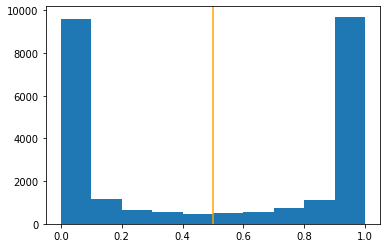

In [15]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [16]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'95.37'